In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, accuracy_score,f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import Pipeline
from nltk.corpus import names
from collections import defaultdict
import os,re
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from keras.preprocessing.text import Tokenizer
from nltk import word_tokenize
from nltk import pos_tag
from nltk import pos_tag_sents
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
newsgroups = fetch_20newsgroups(subset='train') 
data = pd.Series(newsgroups.data)
df = pd.DataFrame(data)
df.columns = ['text'] + df.columns.tolist()[1:]
df['target'] = pd.Series(newsgroups.target)
df['target_names'] = pd.Series(newsgroups.target_names)
df

,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,alt.atheism
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.graphics
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.os.ms-windows.misc
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.sys.ibm.pc.hardware
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,comp.sys.mac.hardware
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,NaN
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,NaN
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,NaN
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,NaN


In [3]:
df1 = pd.read_json ("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")
df1.columns = ['text','target','target_names']
df1

,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [4]:
print('target labels the same: ',(df['target'] == df1['target']).all())
print('text the same: ',(df['text'] == df1['text']).all())
print('target names the same: ',(df['target_names'] == df1['target_names']).all())

target labels the same:  True
text the same:  True
target names the same:  False


In [5]:
target_name_dict = df1[['target','target_names']].drop_duplicates().set_index('target_names')['target'].sort_values().to_dict()
target_name_dict

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

In [47]:
newsgroups = fetch_20newsgroups(subset='all', remove=('quotes'))
data = pd.Series(newsgroups.data)
df = pd.DataFrame(data)
df.columns = ['text'] + df.columns.tolist()[1:]
df['target'] = pd.Series(newsgroups.target)
print(df.text[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [48]:
print('shape of dataframe: ', df.shape)
print('number of target variables: ',df.target.nunique())
print('null target variables: ', df.target.isna().any())
print('null text: ',df.text.isna().any())

shape of dataframe:  (18846, 2)
number of target variables:  20
null target variables:  False
null text:  False


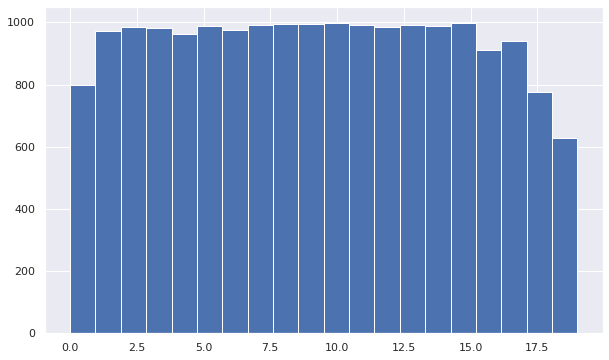

In [49]:
sns.set(rc={'figure.figsize':(10,6)})
df['target'].hist(bins=df.target.nunique())

In [50]:
df

,text,target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4
...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1


In [51]:
#fix apostrophes so all stop words are removed
 
lexicon = (
    (re.compile(r"\bdon't\b"), "do not"),
    (re.compile(r"\bit's\b"), "it is"),
    (re.compile(r"\bi'm\b"), "i am"),
    (re.compile(r"\bi've\b"), "i have"),
    (re.compile(r"\bcan't\b"), "cannot"),
    (re.compile(r"\bdoesn't\b"), "does not"),
    (re.compile(r"\bthat's\b"), "that is"),
    (re.compile(r"\bdidn't\b"), "did not"),
    (re.compile(r"\bi'd\b"), "i would"),
    (re.compile(r"\byou're\b"), "you are"),
    (re.compile(r"\bisn't\b"), "is not"),
    (re.compile(r"\bi'll\b"), "i will"),
    (re.compile(r"\bthere's\b"), "there is"),
    (re.compile(r"\bwon't\b"), "will not"),
    (re.compile(r"\bwoudn't\b"), "would not"),
    (re.compile(r"\bhe's\b"), "he is"),
    (re.compile(r"\bthey're\b"), "they are"),
    (re.compile(r"\bwe're\b"), "we are"),
    (re.compile(r"\blet's\b"), "let us"),
    (re.compile(r"\bhaven't\b"), "have not"),
    (re.compile(r"\bwhat's\b"), "what is"),
    (re.compile(r"\baren't\b"), "are not"),
    (re.compile(r"\bwasn't\b"), "was not"),
    (re.compile(r"\bwouldn't\b"), "would not"),
)

def fix_apostrophes(text):
    text = text.lower()
    
    for pattern, replacement in lexicon:
        text = pattern.sub(replacement, text)

    return text

df.text = df.text.apply(lambda row: fix_apostrophes(row))

In [52]:
#remove emails
df['text'] = df['text'].apply(lambda row: re.sub(r"\S*@\S*\s?","",row))

#remove single quote marks
df['text'] = df['text'].apply(lambda row: re.sub(r"\'","",row))

#make all text lower case
df['text'] = df['text'].str.lower()

#remove numerics
df['text'] = df['text'].apply(lambda row: re.sub(r"\d+","",row))

#remove words with fewer than 3 characters
df['text'] = df['text'].apply(lambda row: re.sub(r'\b\w{1,2}\b', '',row))

#remove extra spaces
df['text'] = df['text'].apply(lambda row: re.sub(r"\s+"," ",row))

df

,text,target
0,from: mamatha devineni ratnam subject: pens fa...,10
1,from: (matthew lawson) subject: which high-per...,3
2,from: (hilmi eren) subject: : armenia says cou...,17
3,"from: (guy dawson) subject: : ide scsi, dma an...",3
4,from: alexander samuel mcdiarmid subject: driv...,4
...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13
18842,from: (richard..dell) subject: : question abou...,12
18843,from: (will estes) subject: mounting cpu coole...,3
18844,from: (steven collins) subject: : sphere from ...,1


In [12]:
df.isna().any()

text      False
target    False
dtype: bool

In [54]:
#instatiate regexptokenizer and remove symbols
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

#tokenize test
df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row['text']),axis=1)

#define stop words
stop_words=set(stopwords.words("english"))

#remove stop words
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])

#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

#lemmatize text
df['lemmatized_list'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df['lemmatized'] = df['lemmatized_list'].apply(lambda x: " ".join(x) )

df.sample(5)

,text,target,tokenized_text,lemmatized_list,lemmatized
14608,from: (tatsuya kawasaki) subject: stering silv...,6,"[tatsuya, kawasaki, subject, stering, silver, ...","[tatsuya, kawasaki, subject, stering, silver, ...",tatsuya kawasaki subject stering silver neckla...
5750,from: (nick pettefar) subject: : what squid? (...,8,"[nick, pettefar, subject, squid, riceburner, r...","[nick, pettefar, subject, squid, riceburner, r...",nick pettefar subject squid riceburner respect...
7275,from: ([efw]-robert feddeler()) subject: : cen...,13,"[efw, robert, feddeler, subject, centrifuge, o...","[efw, robert, feddeler, subject, centrifuge, o...",efw robert feddeler subject centrifuge organiz...
12178,from: uabdpo.dpo.uab.edu!gila (stephen holland...,13,"[uabdpo, dpo, uab, edu, gila, stephen, holland...","[uabdpo, dpo, uab, edu, gila, stephen, holland...",uabdpo dpo uab edu gila stephen holland subjec...
12881,from: (dlp ) subject: : cyrix dlc- cpu reply-:...,3,"[dlp, subject, cyrix, dlc, cpu, reply, dlp, or...","[dlp, subject, cyrix, dlc, cpu, reply, dlp, or...",dlp subject cyrix dlc cpu reply dlp organizati...


In [55]:
print(df.tokenized_text[0])

['mamatha', 'devineni', 'ratnam', 'subject', 'pens', 'fans', 'reactions', 'organization', 'post', 'office', 'carnegie', 'mellon', 'pittsburgh', 'lines', 'nntp', 'posting', 'host', 'andrew', 'cmu', 'edu', 'sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit', 'puzzled', 'bit', 'relieved', 'however', 'going', 'put', 'end', 'non', 'pittsburghers', 'relief', 'bit', 'praise', 'pens', 'man', 'killing', 'devils', 'worse', 'thought', 'jagr', 'showed', 'much', 'better', 'regular', 'season', 'stats', 'also', 'lot', 'fun', 'watch', 'playoffs', 'bowman', 'let', 'jagr', 'lot', 'fun', 'next', 'couple', 'games', 'since', 'pens', 'going', 'beat', 'pulp', 'jersey', 'anyway', 'disappointed', 'see', 'islanders', 'lose', 'final', 'regular', 'season', 'game', 'pens', 'rule']


In [56]:
print(df.lemmatized[0])

mamatha devineni ratnam subject pen fan reaction organization post office carnegie mellon pittsburgh line nntp posting host andrew cmu edu sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule


In [59]:
df.tokenized_text.isna().any()

False

In [60]:
df.rename(columns={'lemmatized':'preprocessed_text'},inplace=True)

df

,text,target,tokenized_text,lemmatized_list,preprocessed_text
0,from: mamatha devineni ratnam subject: pens fa...,10,"[mamatha, devineni, ratnam, subject, pens, fan...","[mamatha, devineni, ratnam, subject, pen, fan,...",mamatha devineni ratnam subject pen fan reacti...
1,from: (matthew lawson) subject: which high-per...,3,"[matthew, lawson, subject, high, performance, ...","[matthew, lawson, subject, high, performance, ...",matthew lawson subject high performance vlb vi...
2,from: (hilmi eren) subject: : armenia says cou...,17,"[hilmi, eren, subject, armenia, says, could, s...","[hilmi, eren, subject, armenia, say, could, sh...",hilmi eren subject armenia say could shoot tur...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,"[guy, dawson, subject, ide, scsi, dma, detach,...","[guy, dawson, subject, ide, scsi, dma, detach,...",guy dawson subject ide scsi dma detach origina...
4,from: alexander samuel mcdiarmid subject: driv...,4,"[alexander, samuel, mcdiarmid, subject, driver...","[alexander, samuel, mcdiarmid, subject, driver...",alexander samuel mcdiarmid subject driver orga...
...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,"[jim, zisfein, subject, migraines, scans, dist...","[jim, zisfein, subject, migraine, scan, distri...",jim zisfein subject migraine scan distribution...
18842,from: (richard..dell) subject: : question abou...,12,"[richard, dell, subject, question, vac, outlet...","[richard, dell, subject, question, vac, outlet...",richard dell subject question vac outlet wirin...
18843,from: (will estes) subject: mounting cpu coole...,3,"[estes, subject, mounting, cpu, cooler, vertic...","[estes, subject, mounting, cpu, cooler, vertic...",estes subject mounting cpu cooler vertical cas...
18844,from: (steven collins) subject: : sphere from ...,1,"[steven, collins, subject, sphere, points, org...","[steven, collins, subject, sphere, point, orga...",steven collins subject sphere point organizati...


In [61]:
wpt = nltk.WordPunctTokenizer()

In [62]:
pos_tag_list = []
for number in range(0,len(df['preprocessed_text'])):
    new_text = []
    text = wpt.tokenize(df['preprocessed_text'][number])
# #     print(text)
    text_tagged = nltk.pos_tag(text)
#     print(text_tagged)
    for word in text_tagged:
        new_text.append(word[0] + "_" + word[1])
        doc = ' '.join(new_text)
    doc_list = wpt.tokenize(doc)
    pos_tag_list.append(doc_list)
        

In [63]:
df.loc[:,'pos_tags'] = pos_tag_list
df['pos_tags'] = df['pos_tags'].apply(lambda x: " ".join(x))
df

,text,target,tokenized_text,lemmatized_list,preprocessed_text,pos_tags
0,from: mamatha devineni ratnam subject: pens fa...,10,"[mamatha, devineni, ratnam, subject, pens, fan...","[mamatha, devineni, ratnam, subject, pen, fan,...",mamatha devineni ratnam subject pen fan reacti...,mamatha_NN devineni_NN ratnam_NN subject_JJ pe...
1,from: (matthew lawson) subject: which high-per...,3,"[matthew, lawson, subject, high, performance, ...","[matthew, lawson, subject, high, performance, ...",matthew lawson subject high performance vlb vi...,matthew_NN lawson_NN subject_JJ high_JJ perfor...
2,from: (hilmi eren) subject: : armenia says cou...,17,"[hilmi, eren, subject, armenia, says, could, s...","[hilmi, eren, subject, armenia, say, could, sh...",hilmi eren subject armenia say could shoot tur...,hilmi_NN eren_NNS subject_JJ armenia_NNS say_V...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,"[guy, dawson, subject, ide, scsi, dma, detach,...","[guy, dawson, subject, ide, scsi, dma, detach,...",guy dawson subject ide scsi dma detach origina...,guy_NN dawson_NN subject_JJ ide_NN scsi_NN dma...
4,from: alexander samuel mcdiarmid subject: driv...,4,"[alexander, samuel, mcdiarmid, subject, driver...","[alexander, samuel, mcdiarmid, subject, driver...",alexander samuel mcdiarmid subject driver orga...,alexander_NN samuel_NN mcdiarmid_NN subject_JJ...
...,...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,"[jim, zisfein, subject, migraines, scans, dist...","[jim, zisfein, subject, migraine, scan, distri...",jim zisfein subject migraine scan distribution...,jim_NN zisfein_NN subject_JJ migraine_NN scan_...
18842,from: (richard..dell) subject: : question abou...,12,"[richard, dell, subject, question, vac, outlet...","[richard, dell, subject, question, vac, outlet...",richard dell subject question vac outlet wirin...,richard_NN dell_NN subject_JJ question_NN vac_...
18843,from: (will estes) subject: mounting cpu coole...,3,"[estes, subject, mounting, cpu, cooler, vertic...","[estes, subject, mounting, cpu, cooler, vertic...",estes subject mounting cpu cooler vertical cas...,estes_NNS subject_JJ mounting_VBG cpu_NN coole...
18844,from: (steven collins) subject: : sphere from ...,1,"[steven, collins, subject, sphere, points, org...","[steven, collins, subject, sphere, point, orga...",steven collins subject sphere point organizati...,steven_RB collins_NNS subject_VBP sphere_RB po...


In [64]:
df['lemmatized_and_pos'] = df.preprocessed_text + ' ' + df.pos_tags



In [65]:
df['lemmatized_and_pos'][0]

'mamatha devineni ratnam subject pen fan reaction organization post office carnegie mellon pittsburgh line nntp posting host andrew cmu edu sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule mamatha_NN devineni_NN ratnam_NN subject_JJ pen_JJ fan_NN reaction_NN organization_NN post_NN office_NN carnegie_NN mellon_NN pittsburgh_NN line_NN nntp_IN posting_VBG host_NN andrew_VBD cmu_JJ edu_JJ sure_JJ bashers_NNS pen_VBP fan_NN pretty_RB confused_JJ lack_NN kind_NN post_NN recent_JJ pen_JJ massacre_NN devil_NN actually_RB bit_RB puzzled_JJ bit_NN relieved_VBD however_RB going_VBG put_VBN end_VB non_NN pittsburghers_NNS reli

In [66]:
#replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [67]:
#drop nan cells
df.dropna(inplace=True)

In [68]:
df

,text,target,tokenized_text,lemmatized_list,preprocessed_text,pos_tags,lemmatized_and_pos
0,from: mamatha devineni ratnam subject: pens fa...,10,"[mamatha, devineni, ratnam, subject, pens, fan...","[mamatha, devineni, ratnam, subject, pen, fan,...",mamatha devineni ratnam subject pen fan reacti...,mamatha_NN devineni_NN ratnam_NN subject_JJ pe...,mamatha devineni ratnam subject pen fan reacti...
1,from: (matthew lawson) subject: which high-per...,3,"[matthew, lawson, subject, high, performance, ...","[matthew, lawson, subject, high, performance, ...",matthew lawson subject high performance vlb vi...,matthew_NN lawson_NN subject_JJ high_JJ perfor...,matthew lawson subject high performance vlb vi...
2,from: (hilmi eren) subject: : armenia says cou...,17,"[hilmi, eren, subject, armenia, says, could, s...","[hilmi, eren, subject, armenia, say, could, sh...",hilmi eren subject armenia say could shoot tur...,hilmi_NN eren_NNS subject_JJ armenia_NNS say_V...,hilmi eren subject armenia say could shoot tur...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,"[guy, dawson, subject, ide, scsi, dma, detach,...","[guy, dawson, subject, ide, scsi, dma, detach,...",guy dawson subject ide scsi dma detach origina...,guy_NN dawson_NN subject_JJ ide_NN scsi_NN dma...,guy dawson subject ide scsi dma detach origina...
4,from: alexander samuel mcdiarmid subject: driv...,4,"[alexander, samuel, mcdiarmid, subject, driver...","[alexander, samuel, mcdiarmid, subject, driver...",alexander samuel mcdiarmid subject driver orga...,alexander_NN samuel_NN mcdiarmid_NN subject_JJ...,alexander samuel mcdiarmid subject driver orga...
...,...,...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,"[jim, zisfein, subject, migraines, scans, dist...","[jim, zisfein, subject, migraine, scan, distri...",jim zisfein subject migraine scan distribution...,jim_NN zisfein_NN subject_JJ migraine_NN scan_...,jim zisfein subject migraine scan distribution...
18842,from: (richard..dell) subject: : question abou...,12,"[richard, dell, subject, question, vac, outlet...","[richard, dell, subject, question, vac, outlet...",richard dell subject question vac outlet wirin...,richard_NN dell_NN subject_JJ question_NN vac_...,richard dell subject question vac outlet wirin...
18843,from: (will estes) subject: mounting cpu coole...,3,"[estes, subject, mounting, cpu, cooler, vertic...","[estes, subject, mounting, cpu, cooler, vertic...",estes subject mounting cpu cooler vertical cas...,estes_NNS subject_JJ mounting_VBG cpu_NN coole...,estes subject mounting cpu cooler vertical cas...
18844,from: (steven collins) subject: : sphere from ...,1,"[steven, collins, subject, sphere, points, org...","[steven, collins, subject, sphere, point, orga...",steven collins subject sphere point organizati...,steven_RB collins_NNS subject_VBP sphere_RB po...,steven collins subject sphere point organizati...


In [24]:
#train test validation split

X,y = df.preprocessed_text,df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [25]:
train_df = X_train.to_frame().merge(y_train.to_frame(),left_index=True,right_index=True)
val_df = X_val.to_frame().merge(y_val.to_frame(),left_index=True,right_index=True)
test_df = X_test.to_frame().merge(y_test.to_frame(),left_index=True,right_index=True)

In [26]:
train_df.to_csv(r'Data/train.csv', index = False)
val_df.to_csv(r'Data/val.csv', index = False)
test_df.to_csv(r'Data/test.csv', index = False)

In [27]:
X,y = df.lemmatized_and_pos,df.target

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(X_train_pos, y_train_pos, test_size=0.25, random_state=42)

In [28]:
train_df_pos = X_train_pos.to_frame().merge(y_train_pos.to_frame(),left_index=True,right_index=True)
val_df_pos = X_val_pos.to_frame().merge(y_val_pos.to_frame(),left_index=True,right_index=True)
test_df_pos = X_test_pos.to_frame().merge(y_test_pos.to_frame(),left_index=True,right_index=True)

train_df_pos.to_csv(r'Data/train_pos.csv', index = False)
val_df_pos.to_csv(r'Data/val_pos.csv', index = False)
test_df_pos.to_csv(r'Data/test_pos.csv', index = False)

In [41]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())

# pd.set_option('display.max_columns', None)

tfidf_train_df.head()

aaa  aaron   ab  abandon  abandoned  abc  abiding  ability  able  abo  \
0  0.0    0.0  0.0      0.0        0.0  0.0      0.0      0.0   0.0  0.0   
1  0.0    0.0  0.0      0.0        0.0  0.0      0.0      0.0   0.0  0.0   
2  0.0    0.0  0.0      0.0        0.0  0.0      0.0      0.0   0.0  0.0   
3  0.0    0.0  0.0      0.0        0.0  0.0      0.0      0.0   0.0  0.0   
4  0.0    0.0  0.0      0.0        0.0  0.0      0.0      0.0   0.0  0.0   

   abolish  abomination  abort  abortion  abraham  abroad  abruptly  absence  \
0      0.0          0.0    0.0       0.0      0.0     0.0       0.0      0.0   
1      0.0          0.0    0.0       0.0      0.0     0.0       0.0      0.0   
2      0.0          0.0    0.0       0.0      0.0     0.0       0.0      0.0   
3      0.0          0.0    0.0       0.0      0.0     0.0       0.0      0.0   
4      0.0          0.0    0.0       0.0      0.0     0.0       0.0      0.0   

   absent  absolute  absolutely  abstract  absurd  absurdity  abuse  abused  \
0     0.0       0.0         0.0       0.0     0.0        0.0    0.0     0.0   
1     0.0       0.0         0.0       0.0     0.0        0.0    0.0     0.0   
2     0.0       0.0         0.0       0.0     0.0        0.0    0.0     0.0   
3     0.0       0.0         0.0       0.0     0.0        0.0    0.0     0.0   
4     0.0       0.0         0.0       0.0     0.0        0.0    0.0     0.0   

   abuser  abusive  abyss   ac  acad  academic  academy  accelerate  \
0     0.0      0.0    0.0  0.0   0.0       0.0      0.0         0.0   
1     0.0      0.0    0.0  0.0   0.0       0.0      0.0         0.0   
2     0.0      0.0    0.0  0.0   0.0       0.0      0.0         0.0   
3     0.0      0.0    0.0  0.0   0.0       0.0      0.0         0.0   
4     0.0      0.0    0.0  0.0   0.0       0.0      0.0         0.0   

   accelerated  acceleration  accelerator  accept  acceptable  acceptance  \
0          0.0           0.0          0.0     0.0         0.0         0.0   
1          0.0           0.0          0.0     0.0         0.0         0.0   
2          0.0           0.0          0.0     0.0         0.0         0.0   
3          0.0           0.0          0.0     0.0         0.0         0.0   
4          0.0           0.0          0.0     0.0         0.0         0.0   

   accepted  accepting  accepts  access  accessed  accessible  accessing  \
0       0.0        0.0      0.0     0.0       0.0         0.0        0.0   
1       0.0        0.0      0.0     0.0       0.0         0.0        0.0   
2       0.0        0.0      0.0     0.0       0.0         0.0        0.0   
3       0.0        0.0      0.0     0.0       0.0         0.0        0.0   
4       0.0        0.0      0.0     0.0       0.0         0.0        0.0   

   accessory  accident  accidental  accidentally  accidently  accommodate  \
0        0.0       0.0         0.0           0.0         0.0          0.0   
1        0.0       0.0         0.0           0.0         0.0          0.0   
2        0.0       0.0         0.0           0.0         0.0          0.0   
3        0.0       0.0         0.0           0.0         0.0          0.0   
4        0.0       0.0         0.0           0.0         0.0          0.0   

   accomodate  accompanied  accompanying  accomplish  accomplished  accord  \
0         0.0          0.0           0.0         0.0           0.0     0.0   
1         0.0          0.0           0.0         0.0           0.0     0.0   
2         0.0          0.0           0.0         0.0           0.0     0.0   
3         0.0          0.0           0.0         0.0           0.0     0.0   
4         0.0          0.0           0.0         0.0           0.0     0.0   

   accordance  according  account  accountable  accounting  accuracy  \
0         0.0        0.0      0.0          0.0         0.0       0.0   
1         0.0        0.0      0.0          0.0         0.0       0.0   
2         0.0        0.0      0.0          0.0         0.0       0.0   
3         0.0        0.

In [30]:
tfidf_val_sparse = tfidf.transform(X_val)
tfidf_val_df = pd.DataFrame(tfidf_val_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_val_df.head()




,aaa,aaron,ab,abandon,abandoned,abc,abiding,ability,able,abo,...,zeus,zinc,zion,zionism,zionist,zip,zone,zoology,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
tfidf_test_sparse = tfidf.transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()

,aaa,aaron,ab,abandon,abandoned,abc,abiding,ability,able,abo,...,zeus,zinc,zion,zionism,zionist,zip,zone,zoology,zoom,zurich
0,0.146684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.388607,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010483,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [32]:
tfidf_pos = TfidfVectorizer(min_df = 10)
tfidf_train_sparse_pos = tfidf_pos.fit_transform(X_train_pos)
tfidf_train_df_pos = pd.DataFrame(tfidf_train_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_train_df_pos.head()

,aaa,aaa_nn,aaron,aaron_nn,ab,ab_nn,abandon,abandoned,abandoned_vbd,abandoned_vbn,...,zip,zip_nn,zone,zone_cd,zone_nn,zoology,zoology_nn,zoom,zoom_nn,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:

tfidf_val_sparse_pos = tfidf_pos.fit_transform(X_val_pos)
tfidf_val_df_pos = pd.DataFrame(tfidf_val_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_val_df_pos.head()

,aaron,aaron_nn,abc,abiding,abiding_vbg,ability,ability_nn,able,able_jj,absence,...,zero_cd,zeus,zeus_nn,zip,zip_nn,zone,zone_cd,zone_nn,zoom,zoom_nn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
tfidf_test_sparse_pos = tfidf_pos.fit_transform(X_test_pos)
tfidf_test_df_pos = pd.DataFrame(tfidf_test_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_test_df_pos.head()

,aaron,aaron_nn,abc,abc_nn,abiding,abiding_vbg,ability,ability_nn,able,able_jj,...,zeus_nn,zionist,zionist_nn,zip,zip_nn,zone,zone_cd,zone_nn,zoology,zoology_nn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.320893,0.325765,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007831,0.007831,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.decomposition import TruncatedSVD

skl_decomp_obj = TruncatedSVD(n_components=3500, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)

In [ ]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()

In [ ]:
skl_decomp_obj_pos = TruncatedSVD(n_components=3500, n_iter=100, random_state=42)

tfidf_lsa_data_pos = skl_decomp_obj_pos.fit_transform(tfidf_train_df_pos)

In [ ]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj_pos.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()

In [ ]:
skl_decomp_obj = TruncatedSVD(n_components=3500, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)

In [ ]:
logreg_pca = LogisticRegression()
logreg     = LogisticRegression()
logreg_param_grid = [{'penalty':['l1', 'l2']},
                 {'tol':[0.0001, 0.0005, 0.001]}]

# knn_pca.fit(pca_data, y_train)
# knn.fit(x_train_scaled, y_train)

grid_lsa_log = GridSearchCV(estimator=logreg_pca,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)

grid_log = GridSearchCV(estimator=logreg,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)


best_lsa_logreg = grid_lsa_log.fit(tfidf_lsa_data, y_train).best_estimator_
best_reg_logreg = grid_log.fit(tfidf_train_df, y_train).best_estimator_

In [ ]:
print("ROC AUC of optimized Logistic Regression on validation data with principal components is :", best_lsa_logreg.score(tfidf_lsa_data, y_train))
print("ROC AUC of optimized Logistic Regression with standard validation data is :", best_reg_logreg.score(tfidf_train_df, y_train))

In [ ]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(precision_score, average='macro')
recall =  make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')
scoring={'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

scoring.items()

In [ ]:
def multiclass_confusion_matrix(true, pred):
    cm = confusion_matrix(true,pred)
    df_cm = pd.DataFrame(cm,
                         index = [f'TRUE_{target}' for target in list(range(0,20))],
                         columns = [f'PRED_{target}' for target in list(range(0,20))])
    sns.heatmap(df_cm, annot=True,annot_kws={'size':10},cmap='Blues',fmt='g')

In [ ]:
# plt.figure(figsize=(10,10))
multiclass_confusion_matrix(y_val,pred_val)
print(f'{accuracy_score.__name__}: {accuracy_score(y_val, pred_val):.4f}')
for scorer in [precision_score,recall_score,f1_score]:
    name = scorer.__name__
    print(f'{name}: {scorer(y_val, pred_val,average="micro"):.4f}')

In [ ]:
tokenizer.word_index